###Тестовое задание от Яндекс Доставки

In [54]:
import glob
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

###Для лучшего восприятия информации загрузим расшифровку колонок

In [56]:
with open("/gdrive/My Drive/Yandex_Delivery/column_breakdown.txt", 'r') as legend:
  print(legend.read())

Расшифровка колонок

models.xlsx

model - модель авто, например, BMW m3
year - год выпуска авто, например, 2020
can_be_branded - можно ли брендировать данную модель данного года в действующем классификаторе
car_cnt - количество машин данной модели и года в сервисе
car_sticker_cnt - количество оклеенных машин данной модели и года в сервисе
trips_success_cnt - количество успешных поездок, которые совершили пользователи на данной модели данного года авто за период анализа
trips_cancel_cnt - количество отмененных поездок, которые совершили пользователи на данной модели данного года авто за период анализа
trips_defect_cnt - количество дефектных поездок (с оценкой меньше 4 из 5), которые совершили пользователи на данной модели данного года авто за период анализа
trips_rated_cnt - количество оцененных поездок, которые совершили пользователи на данной модели данного года авто за период анализа
bad_car_model_tag_cnt - количество тегов "не доволен моделью машины", которые пользователи поставили 

###Ознакомление с данными

In [57]:
df_models = pd.read_excel("/gdrive/My Drive/Yandex_Delivery/models.xlsx")
df_partners = pd.read_excel("/gdrive/My Drive/Yandex_Delivery/partners.xlsx")

In [58]:
df_models.head()

,Unnamed: 0,model,year,can_be_branded,car_cnt,car_sticker_cnt,trips_success_cnt,trips_cancel_cnt,trips_defect_cnt,trips_rated_cnt,bad_car_model_tag_cnt,dissapointed_car_model_tag_cnt
0,0,model_207,year_20,False,1,0,12,3,0,5,0,0
1,1,model_482,year_19,False,1,0,12,4,0,4,0,0
2,2,model_499,year_7,False,1,0,46,1,0,14,0,0
3,3,model_499,year_8,False,3,0,1592,198,10,510,5,1
4,4,model_499,year_9,False,2,0,49,8,0,14,0,0


In [59]:
df_partners.head()

,Unnamed: 0,partner,model,year,car_cnt,car_sticker_cnt
0,0,partner_6613,model_147,year_30,1,0
1,1,partner_7944,model_615,year_26,1,1
2,2,partner_7944,model_576,year_29,1,1
3,3,partner_7944,model_576,year_30,1,0
4,4,partner_7944,model_362,year_23,1,0


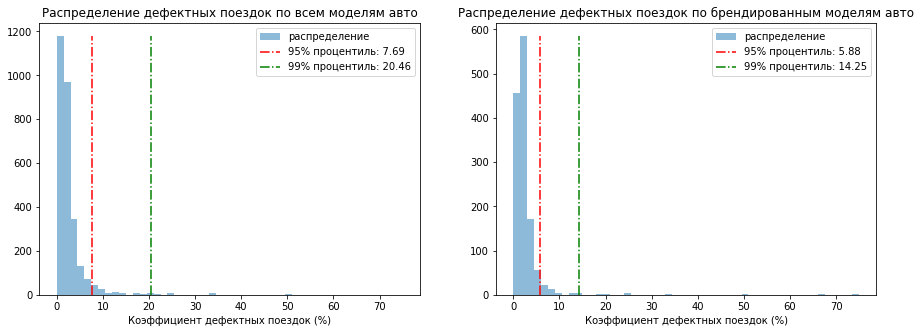

In [60]:
_, axis = plt.subplots(1, 2, figsize=(15, 5), tight_layout=False)

defect_ratio_dist = (df_models['trips_defect_cnt']/df_models['trips_rated_cnt']*100).dropna()
bins = axis[0].hist(defect_ratio_dist, bins=50, label='распределение', alpha=0.5)
axis[0].vlines(np.percentile(defect_ratio_dist, 95), 0, max(bins[0]), 
           linestyles ="dashdot", colors ="r", 
           label='95% процентиль: {:.2f}'.format(np.percentile(defect_ratio_dist, 95)))
axis[0].vlines(np.percentile(defect_ratio_dist, 99), 0, max(bins[0]), 
           linestyles ="dashdot", colors ="g", 
           label='99% процентиль: {:.2f}'.format(np.percentile(defect_ratio_dist, 99)))
axis[0].set_xlabel('Коэффициент дефектных поездок (%)')
axis[0].legend()
axis[0].set_title('Распределение дефектных поездок по всем моделям авто')

defect_ratio_dist = (df_models[df_models['can_be_branded']]['trips_defect_cnt']/df_models[
            df_models['can_be_branded']]['trips_rated_cnt']*100).dropna()
bins = axis[1].hist(defect_ratio_dist, bins=50, label='распределение', alpha=0.5)
axis[1].vlines(np.percentile(defect_ratio_dist, 95), 0, max(bins[0]), 
           linestyles ="dashdot", colors ="r", 
           label='95% процентиль: {:.2f}'.format(np.percentile(defect_ratio_dist, 95)))
axis[1].vlines(np.percentile(defect_ratio_dist, 99), 0, max(bins[0]), 
           linestyles ="dashdot", colors ="g", 
           label='99% процентиль: {:.2f}'.format(np.percentile(defect_ratio_dist, 99)))
axis[1].set_xlabel('Коэффициент дефектных поездок (%)')
axis[1].legend()
axis[1].set_title('Распределение дефектных поездок по брендированным моделям авто')
plt.show()

In [61]:
branded = df_models[df_models['can_be_branded']]
curr_defect_ratio = (branded['trips_defect_cnt']/branded['trips_rated_cnt']).mean()*100
curr_share_of_voice = branded['car_sticker_cnt'].sum()/df_models['car_cnt'].sum()*100
print('Коэффициент дефектных поездок при новом классификаторе: {:.2f}%'.format(curr_defect_ratio))
print('Доля "рекламного голоса" при новом классификаторе: {:.2f}%'.format(curr_share_of_voice))

Коэффициент дефектных поездок при новом классификаторе: 2.42%
Доля "рекламного голоса" при новом классификаторе: 14.04%


In [62]:
df_models['defect_rate%'] = df_models['trips_defect_cnt']/df_models['trips_rated_cnt']*100

In [63]:
def cnt_share_of_voice(defect_rate, 
      motivation = df_models[df_models['can_be_branded']]['car_sticker_cnt'].sum()/df_models[
              df_models['can_be_branded']]['car_cnt'].sum(), unstick_olds=False):
    if unstick_olds:
        branded = df_models[df_models['defect_rate%'] < defect_rate]
        share_of_voice = branded['car_cnt'].sum() * motivation / df_models['car_cnt'].sum()*100
        return share_of_voice

    df_models['branded_tmp'] = (df_models['defect_rate%'] < defect_rate).astype(int)
    df_models['branded_tmp'] = (df_models['can_be_branded']).astype(int) + df_models['branded_tmp']
    branded = df_models[df_models['branded_tmp'] > 0]
    share_of_voice = branded['car_cnt'].sum() * motivation /df_models['car_cnt'].sum()*100
    return share_of_voice

motivation_level = df_models[df_models['can_be_branded']]['car_sticker_cnt'].sum()/df_models[
              df_models['can_be_branded']]['car_cnt'].sum()*100
print('Текущий уровень мотивации: {:.2f}%'.format(motivation_level))    

Текущий уровень мотивации: 17.77%


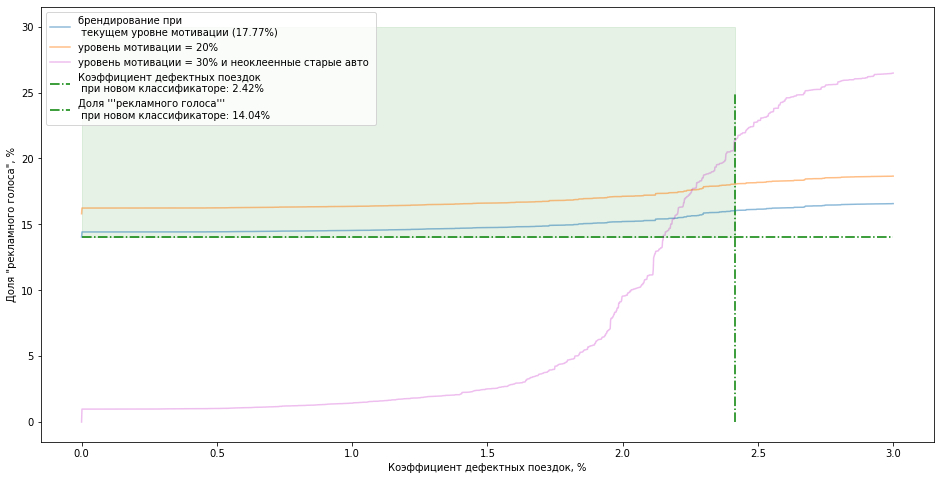

In [64]:
x = np.linspace(0, 3, 2000)
plt.figure(figsize=(16,8))
plt.plot(x, [cnt_share_of_voice(dr) for dr in x], 
         alpha=0.5, label='брендирование при \n текущем уровне мотивации ({:.2f}%)'.format(
             motivation_level
         ))
plt.plot(x, [cnt_share_of_voice(dr, motivation=0.2) for dr in x], 
         alpha=0.5, label='уровень мотивации = 20%')
plt.plot(x, [cnt_share_of_voice(dr, motivation=0.3, unstick_olds=True) for dr in x], 
         alpha=0.25, color='m', label='уровень мотивации = 30% и неоклеенные старые авто '.format(
             motivation_level))
plt.vlines(curr_defect_ratio, 0, 25, 
           linestyles ="dashdot", colors ="g", 
           label="Коэффициент дефектных поездок \n при новом классификаторе: {:.2f}%".format(curr_defect_ratio))
plt.hlines(curr_share_of_voice, 0, 3, 
           linestyles ="dashdot", colors ="g", 
           label="Доля '''рекламного голоса''' \n при новом классификаторе: {:.2f}%".format(curr_share_of_voice))
plt.fill_between([0, curr_defect_ratio], 
                 curr_share_of_voice, 30, color='g', alpha=0.1)
plt.xlabel('Коэффициент дефектных поездок, %')
plt.ylabel('Доля "рекламного голоса", %')
plt.legend()
plt.show()

In [65]:
df_models['branded_tmp'] = list(df_models['defect_rate%'] < 2)
df_models['branded_tmp'] = df_models['branded_tmp'] | df_models['can_be_branded']

tmp1 = df_partners.groupby('partner').sum().reset_index()
tmp = tmp1[tmp1['car_cnt'] > tmp1['car_sticker_cnt']]
tmp['left_to_stick'] = tmp['car_cnt'] - tmp['car_sticker_cnt']
tmp1= tmp[['partner', 'left_to_stick']] 

tmp2 = df_partners.merge(df_models,on=['model', 'year'], suffixes=('_ptn', '_mdl'))[
      ['partner','model','year', 'car_cnt_ptn', 
    'car_sticker_cnt_ptn', 'branded_tmp', 'defect_rate%', 'can_be_branded']]
tmp2['allowed_to_stick_now'] = tmp2['car_cnt_ptn'] - tmp2['car_sticker_cnt_ptn']
tmp2 = tmp2[tmp2['can_be_branded']].groupby('partner').sum()['allowed_to_stick_now'].reset_index()
tmp1 = tmp1.merge(tmp2, how='left')

tmp2 = df_partners.merge(df_models,on=['model', 'year'], suffixes=('_ptn', '_mdl'))[
      ['partner','model','year', 'car_cnt_ptn', 
    'car_sticker_cnt_ptn', 'branded_tmp', 'defect_rate%', 'can_be_branded']]
  
tmp2['allowed_to_stick_then'] = tmp2['car_cnt_ptn'] - tmp2['car_sticker_cnt_ptn']
tmp2 = tmp2[tmp2['branded_tmp']].groupby('partner').sum()['allowed_to_stick_then'].reset_index()
tmp1 = tmp1.merge(tmp2, how='left', on='partner')

tmp1 = tmp1.fillna(0)
tmp1['satisfied_now'] = tmp1['allowed_to_stick_now']/tmp1['left_to_stick']
tmp1['satisfied_then'] = tmp1['allowed_to_stick_then']/tmp1['left_to_stick']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [66]:
print('Усреднённый показатель удовлетворённости ранее: {:.2f}%'.format(tmp1['satisfied_now'].mean()*100))
print('Усреднённый показатель удовлетворённости сейчас: {:.2f}%'.format(tmp1['satisfied_then'].mean()*100))

Усреднённый показатель удовлетворённости ранее: 76.77%
Усреднённый показатель удовлетворённости сейчас: 83.69%


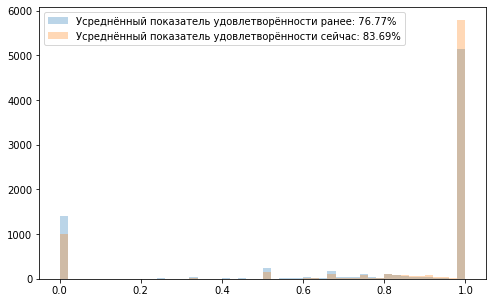

In [67]:
plt.figure(figsize=(8, 5))
plt.hist(tmp1['satisfied_now'], bins=50, alpha=0.3, label='Усреднённый показатель удовлетворённости ранее: 76.77%')
plt.hist(tmp1['satisfied_then'], bins=50, alpha=0.3, label='Усреднённый показатель удовлетворённости сейчас: 83.69%')
plt.legend()
plt.show()

In [68]:
from scipy.stats import wilcoxon
wilcoxon(tmp1['satisfied_now'], tmp1['satisfied_then'])

WilcoxonResult(statistic=0.0, pvalue=2.0436258313700874e-199)